In [63]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt






In [64]:
titanic_train=pd.read_csv("train.csv")
titanic_test=pd.read_csv("test.csv")


In [65]:
titanic_train.isna().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [67]:
titanic_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

# Custom Transformer to perform Feature Engineering
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      
        X_copy = X.copy()

     
        X_copy['Title'] = X_copy['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        # Group rare titles
        rare_titles = ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
        X_copy['Title'] = X_copy['Title'].replace(rare_titles, 'Rare')
        X_copy['Title'] = X_copy['Title'].replace(['Mlle', 'Ms'], 'Miss')
        X_copy['Title'] = X_copy['Title'].replace('Mme', 'Mrs')

       
        bins = [0, 15, 25, 45, 65, 100]
        labels = ['Child', 'YoungAdult', 'Adult', 'Senior', 'Elderly']
   
        X_copy['AgeGroup'] = pd.cut(X_copy['Age'], bins=bins, labels=labels, right=False)

       
        X_copy = X_copy.drop('Name', axis=1)

        return X_copy

<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
C:\Users\effi\AppData\Local\Temp\ipykernel_6128\1814010786.py:14: SyntaxWarning: invalid escape sequence '\.'
  X_copy['Title'] = X_copy['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [68]:

from sklearn.pipeline import Pipeline
###
from sklearn.compose import ColumnTransformer
# Import SimpleImputer from sklearn's impute module
###
from sklearn.impute import SimpleImputer
# Import OneHotEncoder from sklearn's preprocessing module
###
from sklearn.preprocessing import OneHotEncoder

In [99]:
categorical_features = ["Cabin", "Embarked","Sex"]

# Create categorical transformer Pipeline
categorical_transformer = Pipeline(steps=[
    # Set SimpleImputer strategy to "constant" and fill value to "missing"
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    # Set OneHotEncoder to ignore the unknowns
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

In [100]:
# Define numeric features (only the Odometer (KM) column)
numeric_features = ["Age","Pclass","SibSp","Parch","Fare"]

# Crearte numeric transformer Pipeline
numeric_transformer = Pipeline(steps=[
    # Set SimpleImputer strategy to fill missing values with the "Median"
    ("imputer", SimpleImputer(strategy="median"))])

In [101]:
preprocessor = ColumnTransformer(
    transformers=[
        # Use the categorical_transformer to transform the categorical_features
        ("cat", categorical_transformer,categorical_features),
        ("num", numeric_transformer, numeric_features)])

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# Import KNeighborsClassifier from sklearn's neighbors module
###
from sklearn.neighbors import KNeighborsClassifier
# Import SVC from sklearn's svm module
###
from sklearn.svm import SVC
# Import LogisticRegression from sklearn's linear_model module
###
from sklearn.linear_model import LogisticRegression

In [103]:
models = {"LinearSVC": LinearSVC(),
          "KNN": KNeighborsClassifier(),
          "SVC": SVC(),
          "LogisticRegression": LogisticRegression(),
          "RandomForestClassifier": RandomForestClassifier()}
results={}

In [104]:
# Create X (all columns except target)
X = titanic_train.drop('Survived',axis=1)

# Create y (only the target column)
y = titanic_train['Survived']

In [105]:

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [106]:
np.random.seed(42)
for model_name, model in models.items():
    
    # Create a model Pipeline with a preprocessor step and model step
    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("model", model)])
    
    # Fit the model Pipeline to the car sales training data
    print(f"Fitting {model_name}...")
    model_pipeline.fit(X_train, y_train)
    
    # Score the model Pipeline on the test data appending the model_name to the 
    # results dictionary
    print(f"Scoring {model_name}...")
    results[model_name] = model_pipeline.score(X_test, 
                                                    y_test)

Fitting LinearSVC...
Scoring LinearSVC...
Fitting KNN...
Scoring KNN...
Fitting SVC...
Scoring SVC...
Fitting LogisticRegression...
Scoring LogisticRegression...
Fitting RandomForestClassifier...


c:\Users\effi\Desktop\titanic\titanic_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Scoring RandomForestClassifier...


In [107]:
results

{'LinearSVC': 0.7932960893854749,
 'KNN': 0.7206703910614525,
 'SVC': 0.659217877094972,
 'LogisticRegression': 0.8100558659217877,
 'RandomForestClassifier': 0.7877094972067039}

<Axes: >

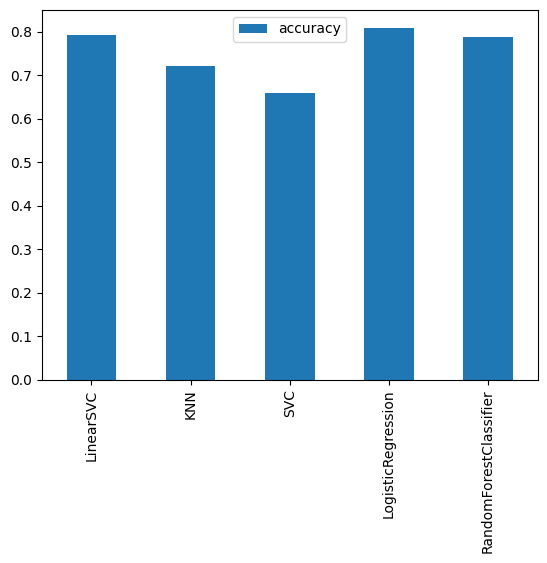

In [108]:
results_df = pd.DataFrame(results.values(), 
                          results.keys(), 
                          columns=['accuracy'])

# Create a bar plot of the results dataframe using plot.bar()
###
results_df.plot.bar()

In [109]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Logistic Regression
param_grid = {
    "model__C": [0.01, 0.1, 1, 10, 100],   
    "model__solver": ["liblinear", "saga"] 
}

# Create pipeline with preprocessing + Logistic Regression
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=500))
])

# Apply GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    cv=5,               
    scoring="accuracy",   
    n_jobs=-1          
)

print("Fitting GridSearchCV for Logistic Regression...")
grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)


test_accuracy = grid_search.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Fitting GridSearchCV for Logistic Regression...
Best Parameters: {'model__C': 10, 'model__solver': 'liblinear'}
Best Cross-validation Accuracy: 0.7991135624938442
Test Accuracy: 0.8100558659217877


In [110]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = grid_search.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [111]:
test_predictions = grid_search.predict(titanic_test)
submission = pd.DataFrame({
    "PassengerId": titanic_test["PassengerId"],
    "Survived": test_predictions
})

# 4. Save to CSV file
submission.to_csv("submission.csv", index=False)

print("✅ Submission file created: submission.csv")

✅ Submission file created: submission.csv


In [ ]:

# 1. Load the file
df = pd.read_csv('submission.csv')

# 2. Sum the 'Survived' column
num_survivors = df['Survived'].sum()

print(f"Total Predicted Survivors: {num_survivors}")

Total Predicted Survivors: 162
